<a class="anchor" id="0"></a>

# Used Cars Price Prediction by 15 different models

Project: Testing some of the most popular models, on the same dataset, to compare their performances.

Comparison of the optimal for each type models.

## 1. Import necessary libraries <a class="anchor" id="1"></a>



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp

from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor 
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor 
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
import sklearn.model_selection
from sklearn.model_selection import cross_val_predict as cvp
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

## 2. Loading the dataset<a class="anchor" id="2"></a>


In [5]:
#Changing default options for better viewing

valid_part = 0.3
pd.set_option('max_columns',100)

In [8]:
train0 = pd.read_csv('craigslistVehicles.csv')
train0.head(5)

url              city  \
0  https://grandrapids.craigslist.org/cto/d/hasti...  grand rapids, MI   
1  https://grandrapids.craigslist.org/cto/d/grand...  grand rapids, MI   
2  https://grandrapids.craigslist.org/ctd/d/chesa...  grand rapids, MI   
3  https://grandrapids.craigslist.org/ctd/d/chesa...  grand rapids, MI   
4  https://grandrapids.craigslist.org/ctd/d/caled...  grand rapids, MI   

                             city_url  price    year manufacturer  \
0  https://grandrapids.craigslist.org   1500  2006.0     cadillac   
1  https://grandrapids.craigslist.org   8900  2009.0      lincoln   
2  https://grandrapids.craigslist.org   7995  2010.0     cadillac   
3  https://grandrapids.craigslist.org   6995  2007.0          NaN   
4  https://grandrapids.craigslist.org  20990  2010.0          ram   

                     make  condition    cylinders    fuel  odometer  \
0                     cts       good  6 cylinders     gas  236000.0   
1                     mkx        NaN          NaN     gas  119000.0   
2  srx premium collection        NaN          NaN     gas  129105.0   
3   hummer h3 4dr 4wd suv        NaN          NaN     gas  164296.0   
4                    2500  excellent  6 cylinders  diesel  123213.0   

  title_status transmission                VIN drive      size   type  \
0        clean    automatic                NaN   rwd  mid-size  coupe   
1        clean    automatic                NaN   NaN       NaN    NaN   
2        clean    automatic  3GYFNCEYXAS552363   NaN       NaN    NaN   
3        clean    automatic  5GTDN13E478107380   NaN       NaN    NaN   
4        clean    automatic  3D7UT2CL4AG113236   4wd       NaN    NaN   

  paint_color                                          image_url  \
0        blue  https://images.craigslist.org/00K0K_a9CZoZg2U8...   
1         NaN  https://images.craigslist.org/00a0a_9B4kPBDIWd...   
2         NaN  https://images.craigslist.org/00X0X_8i0VRuk7Cv...   
3         NaN  https://images.craigslist.org/00b0b_ahkmUzr4cE...   
4       white  https://images.craigslist.org/00505_3DHY0kFrgb...   

                                                desc        lat       long  
0    2006 CtS Leather, Runs and drives Good.236k mil  42.643000 -85.293700  
1  Selling our loaded 2009 Lincoln MKX with 119,0...  42.973700 -85.726500  
2  WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...  43.186723 -84.163862  
3  WE HAVE OVER 400 VEHICLES IN STOCK!\n\n View O...  43.186723 -84.163862  
4  Great looking 2010 Ram 2500 ST w/6.7L 24V I6 4...  42.783714 -85.506777

In [9]:
#Dropping unnecessary columns

drop_columns = ['url', 'city', 'city_url', 'make', 'title_status', 'VIN', 'size', 'image_url', 'desc', 'lat','long']
train0 = train0.drop(columns = drop_columns)

In [10]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525839 entries, 0 to 525838
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         525839 non-null  int64  
 1   year          524399 non-null  float64
 2   manufacturer  501260 non-null  object 
 3   condition     279881 non-null  object 
 4   cylinders     315439 non-null  object 
 5   fuel          521544 non-null  object 
 6   odometer      427248 non-null  float64
 7   transmission  521572 non-null  object 
 8   drive         374475 non-null  object 
 9   type          376906 non-null  object 
 10  paint_color   354306 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 44.1+ MB


In [11]:
train0 = train0.dropna()
train0.head(5)

price    year manufacturer  condition    cylinders fuel  odometer  \
0   1500  2006.0     cadillac       good  6 cylinders  gas  236000.0   
5   4950  2010.0       subaru       good  4 cylinders  gas  253000.0   
6   6850  2007.0          gmc       good  8 cylinders  gas  254000.0   
7   7995  2007.0        lexus  excellent  6 cylinders  gas  146111.0   
8   4995  2011.0      hyundai  excellent  4 cylinders  gas  115048.0   

  transmission drive   type paint_color  
0    automatic   rwd  coupe        blue  
5    automatic   4wd  sedan       white  
6    automatic   4wd  wagon       black  
7    automatic   fwd  sedan       white  
8    automatic   fwd  sedan        blue

In [12]:
# Determination categorical features
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = train0.columns.values.tolist()
for col in features:
    if train0[col].dtype in numerics: continue
    categorical_columns.append(col)
# Encoding categorical features
for col in categorical_columns:
    if col in train0.columns:
        le = LabelEncoder()
        le.fit(list(train0[col].astype(str).values))
        train0[col] = le.transform(list(train0[col].astype(str).values))

In [13]:
train0['year'] = (train0['year']-1900).astype(int)
train0['odometer'] = train0['odometer'].astype(int)

In [14]:
train0.head(10)

price  year  manufacturer  condition  cylinders  fuel  odometer  \
0    1500   106             6          2          5     2    236000   
5    4950   110            36          2          3     2    253000   
6    6850   107            14          2          6     2    254000   
7    7995   107            23          0          5     2    146111   
8    4995   111            17          0          3     2    115048   
9   12995   113            37          0          3     2     72936   
12   8000   110             3          2          5     2    150000   
18   6995   111             7          0          5     2    102000   
21  39000   117             7          0          6     2     43300   
24   8900   112            33          2          6     2    112000   

    transmission  drive  type  paint_color  
0              0      2     3            1  
5              0      0     9           10  
6              0      0    12            0  
7              0      1     9           10  
8              0      1     9            1  
9              0      1     4           10  
12             0      0     9            5  
18             0      1     9            1  
21             0      2     9            5  
24             0      2     8           10

In [15]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144903 entries, 0 to 525836
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   price         144903 non-null  int64
 1   year          144903 non-null  int64
 2   manufacturer  144903 non-null  int64
 3   condition     144903 non-null  int64
 4   cylinders     144903 non-null  int64
 5   fuel          144903 non-null  int64
 6   odometer      144903 non-null  int64
 7   transmission  144903 non-null  int64
 8   drive         144903 non-null  int64
 9   type          144903 non-null  int64
 10  paint_color   144903 non-null  int64
dtypes: int64(11)
memory usage: 13.3 MB


## 3. EDA <a class="anchor" id="3"></a>

In [16]:
train0['price'].value_counts()

0        6755
1        1743
4500     1603
3500     1593
2500     1528
         ... 
12761       1
5445        1
25470       1
26810       1
3297        1
Name: price, Length: 6578, dtype: int64

In [17]:
train0 = train0[train0['price'] > 1000]
train0 = train0[train0['price'] < 40000]
# Rounding 'odometer' to 5000
train0['odometer'] = train0['odometer'] // 5000
train0 = train0[train0['year'] > 110]

In [18]:
train0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61500 entries, 8 to 525835
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   price         61500 non-null  int64
 1   year          61500 non-null  int64
 2   manufacturer  61500 non-null  int64
 3   condition     61500 non-null  int64
 4   cylinders     61500 non-null  int64
 5   fuel          61500 non-null  int64
 6   odometer      61500 non-null  int64
 7   transmission  61500 non-null  int64
 8   drive         61500 non-null  int64
 9   type          61500 non-null  int64
 10  paint_color   61500 non-null  int64
dtypes: int64(11)
memory usage: 5.6 MB


In [19]:
train0.corr()

price      year  manufacturer  condition  cylinders  \
price         1.000000  0.458124     -0.024179   0.061167   0.531244   
year          0.458124  1.000000      0.045498   0.111609  -0.078526   
manufacturer -0.024179  0.045498      1.000000  -0.009447  -0.201032   
condition     0.061167  0.111609     -0.009447   1.000000   0.016719   
cylinders     0.531244 -0.078526     -0.201032   0.016719   1.000000   
fuel         -0.208566  0.069939     -0.065246   0.038039  -0.109350   
odometer     -0.184752 -0.296953     -0.021403  -0.054486   0.066435   
transmission  0.105238  0.036089      0.026844   0.121792   0.052527   
drive        -0.267012  0.010158     -0.101821   0.061101  -0.153713   
type          0.061335  0.026916      0.026859   0.028917   0.096659   
paint_color   0.030263  0.040059     -0.003125   0.022872   0.037153   

                  fuel  odometer  transmission     drive      type  \
price        -0.208566 -0.184752      0.105238 -0.267012  0.061335   
year          0.069939 -0.296953      0.036089  0.010158  0.026916   
manufacturer -0.065246 -0.021403      0.026844 -0.101821  0.026859   
condition     0.038039 -0.054486      0.121792  0.061101  0.028917   
cylinders    -0.109350  0.066435      0.052527 -0.153713  0.096659   
fuel          1.000000 -0.089144      0.068673  0.096037 -0.132572   
odometer     -0.089144  1.000000     -0.074429 -0.046763  0.020417   
transmission  0.068673 -0.074429      1.000000  0.064781 -0.007124   
drive         0.096037 -0.046763      0.064781  1.000000  0.118371   
type         -0.132572  0.020417     -0.007124  0.118371  1.000000   
paint_color  -0.042783  0.022202     -0.026939  0.073252  0.069675   

              paint_color  
price            0.030263  
year             0.040059  
manufacturer    -0.003125  
condition        0.022872  
cylinders        0.037153  
fuel            -0.042783  
odometer         0.022202  
transmission    -0.026939  
drive            0.073252  
type             0.069675  
paint_color      1.000000

In [20]:
train0.describe()

price          year  manufacturer     condition     cylinders  \
count  61500.000000  61500.000000  61500.000000  61500.000000  61500.000000   
mean   16753.402407    114.093057     18.171024      1.037512      4.452244   
std     8634.636138      2.198127     10.783879      1.227185      1.273357   
min     1025.000000    111.000000      0.000000      0.000000      0.000000   
25%     9900.000000    112.000000     10.000000      0.000000      3.000000   
50%    14997.000000    114.000000     14.000000      0.000000      5.000000   
75%    22500.000000    116.000000     30.000000      2.000000      6.000000   
max    39999.000000    120.000000     39.000000      5.000000      7.000000   

               fuel      odometer  transmission         drive          type  \
count  61500.000000  61500.000000  61500.000000  61500.000000  61500.000000   
mean       1.915122     16.275382      0.117220      0.687545      6.161366   
std        0.509889     18.522399      0.423922      0.726215      4.185255   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      9.000000      0.000000      0.000000      0.000000   
50%        2.000000     15.000000      0.000000      1.000000      8.000000   
75%        2.000000     22.000000      0.000000      1.000000      9.000000   
max        4.000000   1926.000000      2.000000      2.000000     12.000000   

        paint_color  
count  61500.000000  
mean       5.612894  
std        4.075558  
min        0.000000  
25%        1.000000  
50%        7.000000  
75%       10.000000  
max       11.000000

In [21]:
pp.ProfileReport(train0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Preparing to train the models <a class="anchor" id="4"></a>

In [22]:
target_name = 'price'
train_target0 = train0[target_name]
train0 = train0.drop([target_name], axis=1)

In [23]:
# Splitting the dataset into training and testing (80-20)
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)

In [24]:
# For boosting model
train0b = train0
train_target0b = train_target0

trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)

In [25]:
#For models from Sklearn to match the shape
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)

In [26]:
train0.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
0  0.863012      1.738647  -0.847094   0.427812  0.165521 -0.469822   
1  0.408926      0.627842   1.595253  -1.141380  0.165521 -0.266986   
2 -1.407417      1.923781  -0.847094  -0.356784  0.165521  0.392231   

   transmission     drive      type  paint_color  
0     -0.277197 -0.946534  0.914222     0.830914  
1     -0.277197 -0.946534 -1.478710     0.585384  
2     -0.277197  0.429470 -1.000124     0.585384

In [27]:
len(train0)

49200

In [28]:
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [29]:
train.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
27131 -0.499245     -0.482963   0.781138   0.427812  0.165521  0.341522   
26736 -0.499245     -0.112695  -0.847094  -1.141380  0.165521 -0.064150   
45445 -1.407417      1.368378  -0.847094   1.212408  0.165521  0.189395   

       transmission     drive      type  paint_color  
27131     -0.277197 -0.946534 -1.478710    -1.378855  
26736     -0.277197  0.429470  0.674928    -1.378855  
45445     -0.277197 -0.946534  0.914222    -1.378855

In [30]:
test.head(3)

year  manufacturer  condition  cylinders      fuel  odometer  \
44567 -0.045159      0.165006   1.595253   0.427812  0.165521 -0.469822   
7230   2.225269     -0.205262  -0.847094   0.427812  0.165521 -0.672658   
6341  -1.407417     -0.112695  -0.847094  -1.141380  0.165521  0.240104   

       transmission     drive      type  paint_color  
44567     -0.277197 -0.946534 -0.042951     1.076444  
7230      -0.277197  0.429470 -0.282244    -1.133325  
6341      -0.277197  0.429470  0.674928     0.830914

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34440 entries, 27131 to 2732
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          34440 non-null  float64
 1   manufacturer  34440 non-null  float64
 2   condition     34440 non-null  float64
 3   cylinders     34440 non-null  float64
 4   fuel          34440 non-null  float64
 5   odometer      34440 non-null  float64
 6   transmission  34440 non-null  float64
 7   drive         34440 non-null  float64
 8   type          34440 non-null  float64
 9   paint_color   34440 non-null  float64
dtypes: float64(10)
memory usage: 2.9 MB


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14760 entries, 44567 to 19061
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          14760 non-null  float64
 1   manufacturer  14760 non-null  float64
 2   condition     14760 non-null  float64
 3   cylinders     14760 non-null  float64
 4   fuel          14760 non-null  float64
 5   odometer      14760 non-null  float64
 6   transmission  14760 non-null  float64
 7   drive         14760 non-null  float64
 8   type          14760 non-null  float64
 9   paint_color   14760 non-null  float64
dtypes: float64(10)
memory usage: 1.2 MB


In [33]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []

In [34]:
def acc_d(y_meas, y_pred):
    # Relative error between predicted y_pred and measured y_meas values
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    # RMSE between predicted y_pred and measured y_meas values
    return (mean_squared_error(y_meas, y_pred))**0.5

In [35]:
def acc_boosting_model(num,model,train,test,num_iteration=0):
    # Calculation of accuracy of boosting model by different metrics
    
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [36]:
def acc_model(num,model,train,test):
    # Calculation of accuracy of model акщь Sklearn by different metrics   
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

## 5. Training models and testing for all features <a class="anchor" id="5"></a>

### 5.1 Linear Regression <a class="anchor" id="5.1"></a>

In [37]:
# Linear Regression

linreg = LinearRegression()
linreg.fit(train, target)
acc_model(0,linreg,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.8844431   8397.2939732  17733.57593104 10134.9269719
  6283.88038457]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.15
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.93475801 27356.28728167  4431.23183339 19550.04053874
 24919.25787533]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555802.12


### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

In [38]:
# Support Vector Machines

svr = SVR()
svr.fit(train, target)
acc_model(1,svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15217.26259365 13081.93378758 15591.30587964 13563.74970446
 12526.56611499]
acc(r2_score) for train = 14.88
acc(relative error) for train = 37.14
acc(rmse) for train = 796758.93
target_test = [38000 31550  5900 13500 35000]
ytest = [15987.95742866 16598.27499562 12663.40871752 15593.55138322
 16346.69567724]
acc(r2_score) for test = 14.56
acc(relative error) for test = 36.92
acc(rmse) for test = 796920.98


### 5.3 Linear SVR <a class="anchor" id="5.3"></a>

In [39]:
# Linear SVR

linear_svr = LinearSVR()
linear_svr.fit(train, target)
acc_model(2,linear_svr,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [13776.56617384  7635.92038031 14564.88153548  8824.96775131
  5997.96258332]
acc(r2_score) for train = 43.93
acc(relative error) for train = 27.61
acc(rmse) for train = 646643.37
target_test = [38000 31550  5900 13500 35000]
ytest = [16976.51057468 21695.55146728  4650.77275104 15832.01456014
 20519.39772999]
acc(r2_score) for test = 35.55
acc(relative error) for test = 27.7
acc(rmse) for test = 692159.34


### 5.4 MLPRegressor <a class="anchor" id="5.4"></a>

In [40]:
# MLPRegressor

mlp = MLPRegressor()
param_grid = {'hidden_layer_sizes': [i for i in range(2,20)],
              'activation': ['relu'],
              'solver': ['adam'],
              'learning_rate': ['constant'],
              'learning_rate_init': [0.01],
              'power_t': [0.5],
              'alpha': [0.0001],
              'max_iter': [1000],
              'early_stopping': [True],
              'warm_start': [False]}
mlp_GS = GridSearchCV(mlp, param_grid=param_grid, 
                   cv=10, verbose=True, pre_dispatch='2*n_jobs')
mlp_GS.fit(train, target)
acc_model(3,mlp_GS,train,test)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
target =  [14888  8995 16990  5600  5490]
ytrain =  [14001.20358356  8179.05682593 18272.67036583  8277.47879791
  6349.28636822]
acc(r2_score) for train = 74.4
acc(relative error) for train = 19.09
acc(rmse) for train = 436940.06
target_test = [38000 31550  5900 13500 35000]
ytest = [20499.57261371 25433.30995964  6883.51681311 17398.39952695
 30518.35603174]
acc(r2_score) for test = 74.12
acc(relative error) for test = 19.01
acc(rmse) for test = 438580.9


### 5.5 Stochastic Gradient Descent <a class="anchor" id="5.5"></a>

In [41]:
# Stochastic Gradient Descent

sgd = SGDRegressor()
sgd.fit(train, target)
acc_model(4,sgd,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17476.21861069  8598.29242249 18143.91043435 10068.51459888
  6279.74840142]
acc(r2_score) for train = 61.39
acc(relative error) for train = 23.76
acc(rmse) for train = 536606.77
target_test = [38000 31550  5900 13500 35000]
ytest = [20552.45254151 27769.88261056  4268.90659399 20048.14562601
 25154.88202517]
acc(r2_score) for test = 55.72
acc(relative error) for test = 23.79
acc(rmse) for test = 573667.54


### 5.6 Decision Tree Regressor <a class="anchor" id="5.6"></a>

In [42]:
# Decision Tree Regression

decision_tree = DecisionTreeRegressor()
decision_tree.fit(train, target)
acc_model(5,decision_tree,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11944.    8869.75 15996.25  5600.    5490.  ]
acc(r2_score) for train = 99.31
acc(relative error) for train = 0.96
acc(rmse) for train = 71730.45
target_test = [38000 31550  5900 13500 35000]
ytest = [38000.         33588.          7131.66666667 11500.
 20999.        ]
acc(r2_score) for test = 76.28
acc(relative error) for test = 14.49
acc(rmse) for test = 419868.14


### 5.7 Random Forest <a class="anchor" id="5.7"></a>

In [43]:
# Random Forest

#random_forest = GridSearchCV(estimator=RandomForestRegressor(), param_grid={'n_estimators': [100, 1000]}, cv=5)
random_forest = RandomForestRegressor()
random_forest.fit(train, target)
print(random_forest.best_params_)
acc_model(6,random_forest,train,test)

AttributeError: 'RandomForestRegressor' object has no attribute 'best_params_'

In [44]:
acc_model(6,random_forest,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [11995.41814286  8873.00243239 15908.06380952  5852.52
  5454.08      ]
acc(r2_score) for train = 97.51
acc(relative error) for train = 4.97
acc(rmse) for train = 136321.96
target_test = [38000 31550  5900 13500 35000]
ytest = [33415.36       30859.14        7177.24946429 16234.18333333
 30477.57388889]
acc(r2_score) for test = 86.02
acc(relative error) for test = 12.12
acc(rmse) for test = 322310.64


### 5.8 XGB<a class="anchor" id="5.8"></a>

In [60]:
xgb_clf = xgb.XGBRegressor({'objective':'reg:squarederror'}) 
parameters = {'n_estimators': [60, 100, 120, 140], 
              'learning_rate': [0.01, 0.1],
              'max_depth': [5, 7],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1,error_score='raise').fit(trainb, targetb)
#print("Best score: %0.3f" % xgb_reg.best_score_)
#print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(7,xgb_reg,trainb,testb)

target =  [14888  8995 16990  5600  5490]
ytrain =  [12931.741  8366.024 17058.498  7059.074  5782.543]
acc(r2_score) for train = 87.7
acc(relative error) for train = 12.95
acc(rmse) for train = 302861.88
target_test = [38000 31550  5900 13500 35000]
ytest = [26643.826  27002.285   6544.8574 15417.398  32541.28  ]
acc(r2_score) for test = 84.66
acc(relative error) for test = 14.19
acc(rmse) for test = 337698.16


### 5.9 GradientBoostingRegressor<a class="anchor" id="5.10"></a>

In [61]:
def hyperopt_gb_score(params):
    clf = GradientBoostingRegressor(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.8589895427255876                                                              
{'max_depth': 9, 'n_estimators': 194}                                           
0.8616411446939569                                                              
{'max_depth': 8, 'n_estimators': 662}                                           
0.7915707074736504                                                              
{'max_depth': 2, 'n_estimators': 408}                                           
0.8199051267758246                                                              
{'max_depth': 3, 'n_estimators': 548}                                           
0.8600093009579008                                                              
{'max_depth': 7, 'n_estimators': 994}                                           
0.8593014098424                                                                 
{'max_depth': 7, 'n_estimators': 673}                                           
0.8494278598387194          

In [62]:
params = space_eval(space_gb, best)
params

{'max_depth': 2, 'n_estimators': 408}

In [63]:
# Gradient Boosting Regression

gradient_boosting = GradientBoostingRegressor(**params)
gradient_boosting.fit(train, target)
acc_model(9,gradient_boosting,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [14035.18079798  8336.13582241 17986.47430424  7605.80446461
  7270.29401932]
acc(r2_score) for train = 79.59
acc(relative error) for train = 17.11
acc(rmse) for train = 390176.25
target_test = [38000 31550  5900 13500 35000]
ytest = [22459.67837066 25007.30166424  5771.00532506 17503.86844453
 30794.06932852]
acc(r2_score) for test = 79.35
acc(relative error) for test = 17.0
acc(rmse) for test = 391750.81


### 5.10 RidgeRegressor <a class="anchor" id="5.11"></a>

In [64]:
# Ridge Regressor

ridge = RidgeCV(cv=5)
ridge.fit(train, target)
acc_model(10,ridge,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [17220.74260172  8399.64685999 17733.15673909 10137.097247
  6286.78880675]
acc(r2_score) for train = 61.64
acc(relative error) for train = 23.91
acc(rmse) for train = 534865.19
target_test = [38000 31550  5900 13500 35000]
ytest = [20341.45202939 27352.66613376  4434.95517174 19549.19011371
 24916.23870525]
acc(r2_score) for test = 58.44
acc(relative error) for test = 23.89
acc(rmse) for test = 555793.6


### 5.11 AdaBoost Regressor <a class="anchor" id="5.14"></a>

In [65]:
# AdaBoost Regression

Ada_Boost = AdaBoostRegressor()
Ada_Boost.fit(train, target)
acc_model(13,Ada_Boost,train,test)

target =  [14888  8995 16990  5600  5490]
ytrain =  [15712.10657823 11329.39806943 17463.13450075 11876.291788
 10755.80963046]
acc(r2_score) for train = 63.14
acc(relative error) for train = 25.15
acc(rmse) for train = 524301.28
target_test = [38000 31550  5900 13500 35000]
ytest = [23247.54437048 22911.73980392  9669.68148296 21898.61467608
 27068.5011705 ]
acc(r2_score) for test = 63.07
acc(relative error) for test = 24.96
acc(rmse) for test = 523922.7


## 6. Models comparison <a class="anchor" id="6"></a>

In [66]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Support Vector Machines', 'Linear SVR', 
              'MLPRegressor', 'Stochastic Gradient Decent', 
              'Decision Tree Regressor', 'Random Forest',  'XGB',
              'GradientBoostingRegressor', 'RidgeRegressor', 
              'AdaBoostRegressor'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [67]:
pd.options.display.float_format = '{:,.2f}'.format

In [68]:
print('Prediction accuracy for models by R2 criterion - r2_test')
models.sort_values(by=['r2_test', 'r2_train'], ascending=False)

Prediction accuracy for models by R2 criterion - r2_test


Model  r2_train  r2_test  d_train  d_test  \
6                Random Forest     97.51    86.02     4.97   12.12   
7                          XGB     87.70    84.66    12.95   14.19   
8    GradientBoostingRegressor     79.59    79.35    17.11   17.00   
5      Decision Tree Regressor     99.31    76.28     0.96   14.49   
3                 MLPRegressor     74.40    74.12    19.09   19.01   
10           AdaBoostRegressor     63.14    63.07    25.15   24.96   
0            Linear Regression     61.64    58.44    23.91   23.89   
9               RidgeRegressor     61.64    58.44    23.91   23.89   
4   Stochastic Gradient Decent     61.39    55.72    23.76   23.79   
2                   Linear SVR     43.93    35.55    27.61   27.70   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
6   136,321.96 322,310.64  
7   302,861.88 337,698.16  
8   390,176.25 391,750.81  
5    71,730.45 419,868.14  
3   436,940.06 438,580.90  
10  524,301.28 523,922.70  
0   534,865.15 555,802.12  
9   534,865.19 555,793.60  
4   536,606.77 573,667.54  
2   646,643.37 692,159.34  
1   796,758.93 796,920.98

In [69]:
print('Prediction accuracy for models by relative error - d_test')
models.sort_values(by=['d_test', 'd_train'], ascending=True)

Prediction accuracy for models by relative error - d_test


Model  r2_train  r2_test  d_train  d_test  \
6                Random Forest     97.51    86.02     4.97   12.12   
7                          XGB     87.70    84.66    12.95   14.19   
5      Decision Tree Regressor     99.31    76.28     0.96   14.49   
8    GradientBoostingRegressor     79.59    79.35    17.11   17.00   
3                 MLPRegressor     74.40    74.12    19.09   19.01   
4   Stochastic Gradient Decent     61.39    55.72    23.76   23.79   
0            Linear Regression     61.64    58.44    23.91   23.89   
9               RidgeRegressor     61.64    58.44    23.91   23.89   
10           AdaBoostRegressor     63.14    63.07    25.15   24.96   
2                   Linear SVR     43.93    35.55    27.61   27.70   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
6   136,321.96 322,310.64  
7   302,861.88 337,698.16  
5    71,730.45 419,868.14  
8   390,176.25 391,750.81  
3   436,940.06 438,580.90  
4   536,606.77 573,667.54  
0   534,865.15 555,802.12  
9   534,865.19 555,793.60  
10  524,301.28 523,922.70  
2   646,643.37 692,159.34  
1   796,758.93 796,920.98

In [70]:
print('Prediction accuracy for models by RMSE - rmse_test')
models.sort_values(by=['rmse_test', 'rmse_train'], ascending=True)

Prediction accuracy for models by RMSE - rmse_test


Model  r2_train  r2_test  d_train  d_test  \
6                Random Forest     97.51    86.02     4.97   12.12   
7                          XGB     87.70    84.66    12.95   14.19   
8    GradientBoostingRegressor     79.59    79.35    17.11   17.00   
5      Decision Tree Regressor     99.31    76.28     0.96   14.49   
3                 MLPRegressor     74.40    74.12    19.09   19.01   
10           AdaBoostRegressor     63.14    63.07    25.15   24.96   
9               RidgeRegressor     61.64    58.44    23.91   23.89   
0            Linear Regression     61.64    58.44    23.91   23.89   
4   Stochastic Gradient Decent     61.39    55.72    23.76   23.79   
2                   Linear SVR     43.93    35.55    27.61   27.70   
1      Support Vector Machines     14.88    14.56    37.14   36.92   

    rmse_train  rmse_test  
6   136,321.96 322,310.64  
7   302,861.88 337,698.16  
8   390,176.25 391,750.81  
5    71,730.45 419,868.14  
3   436,940.06 438,580.90  
10  524,301.28 523,922.70  
9   534,865.19 555,793.60  
0   534,865.15 555,802.12  
4   536,606.77 573,667.54  
2   646,643.37 692,159.34  
1   796,758.93 796,920.98

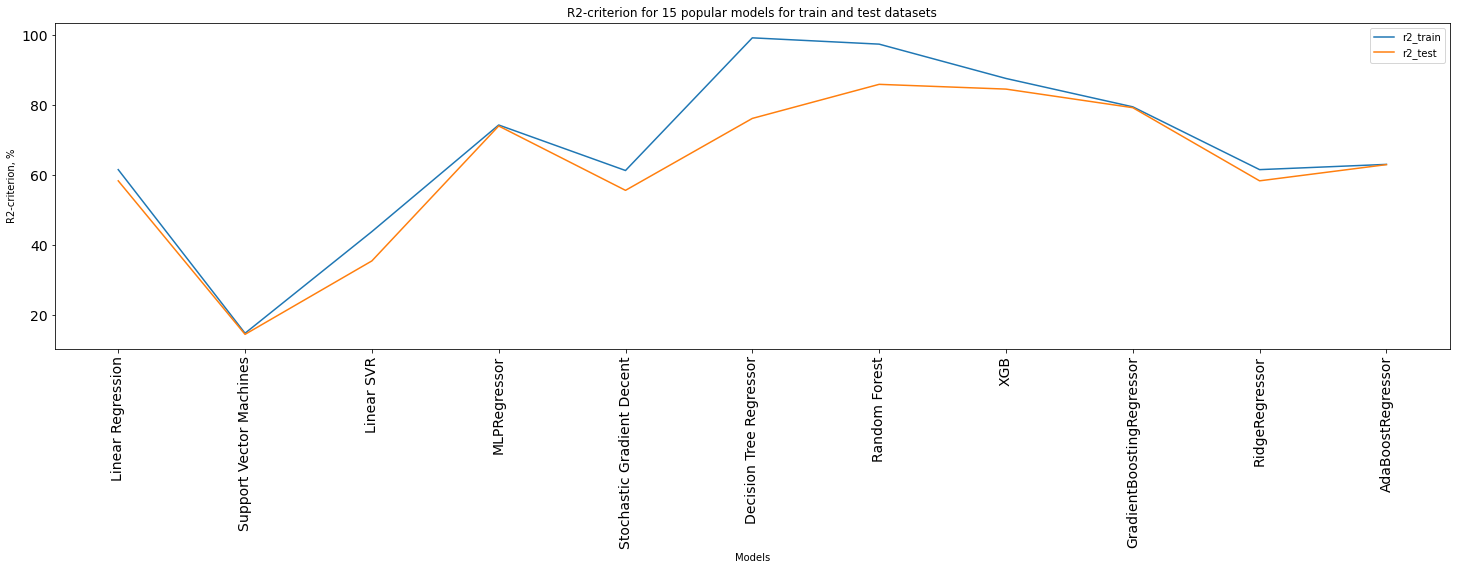

In [71]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['r2_train'], label = 'r2_train')
plt.plot(xx, models['r2_test'], label = 'r2_test')
plt.legend()
plt.title('R2-criterion for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('R2-criterion, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

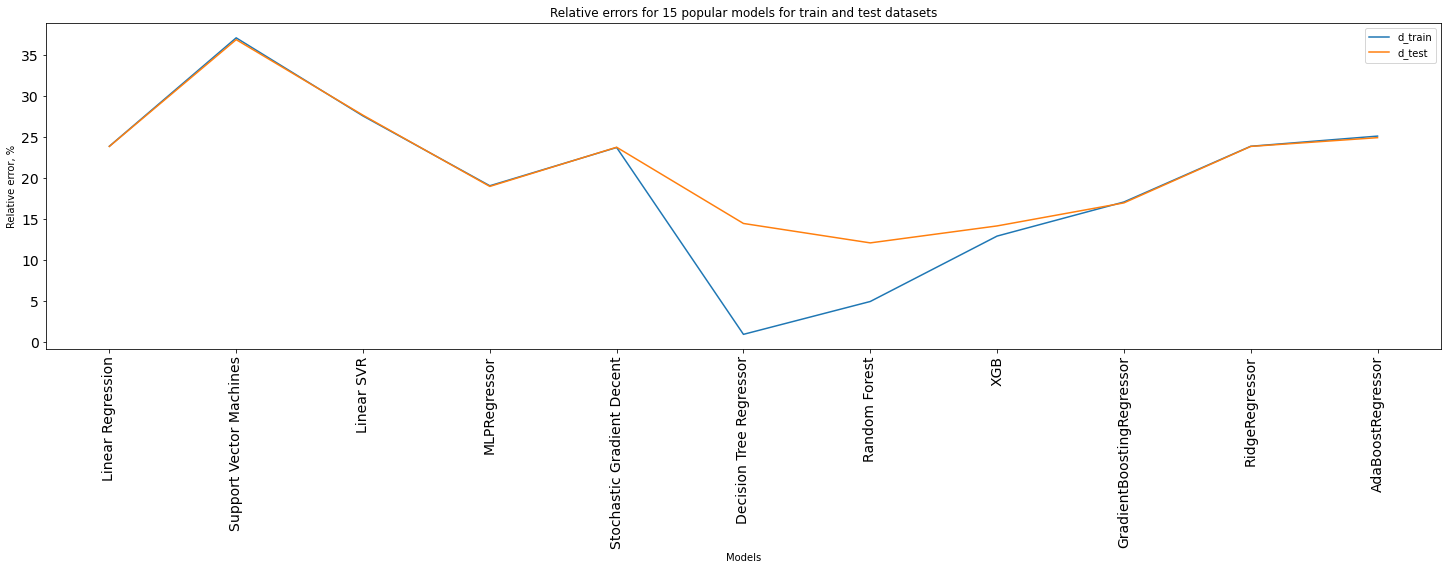

In [72]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['d_train'], label = 'd_train')
plt.plot(xx, models['d_test'], label = 'd_test')
plt.legend()
plt.title('Relative errors for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Relative error, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

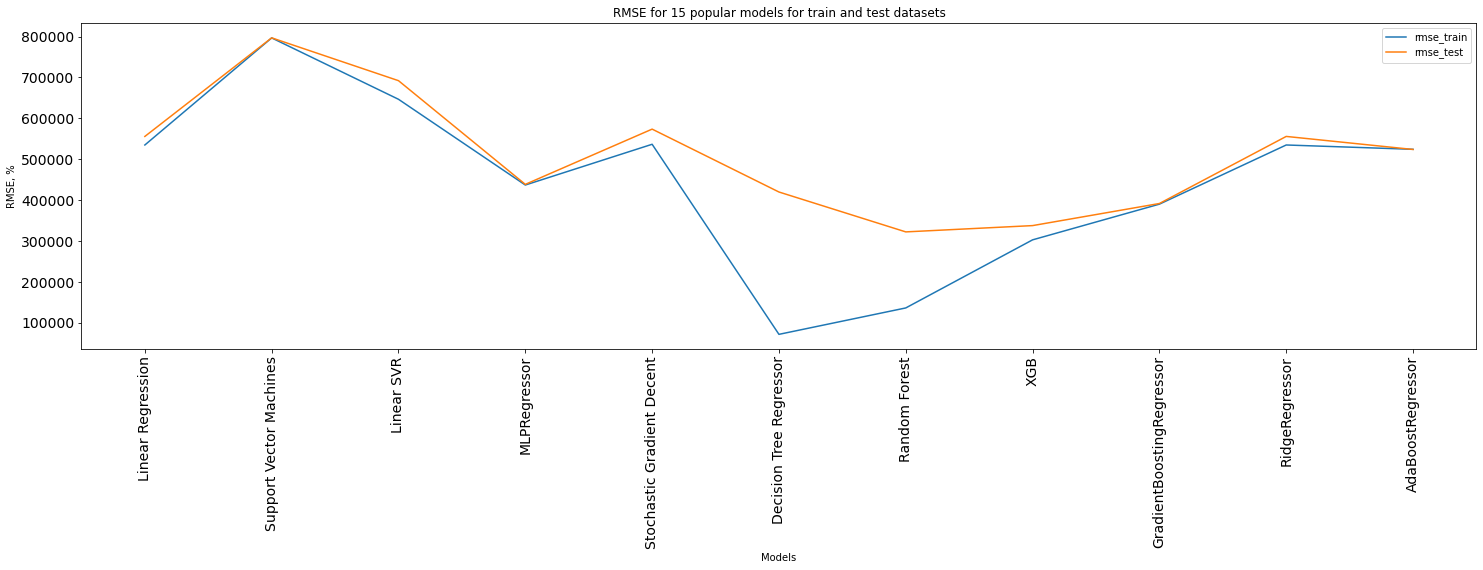

In [73]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['rmse_train'], label = 'rmse_train')
plt.plot(xx, models['rmse_test'], label = 'rmse_test')
plt.legend()
plt.title('RMSE for 15 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('RMSE, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

Thus, the best models by the RMSE are Linear Regression and Ridge Regressor.

## 7. Prediction <a class="anchor" id="7"></a>

In [74]:
test0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12300 entries, 4125 to 4066
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   year          12300 non-null  int64
 1   manufacturer  12300 non-null  int64
 2   condition     12300 non-null  int64
 3   cylinders     12300 non-null  int64
 4   fuel          12300 non-null  int64
 5   odometer      12300 non-null  int64
 6   transmission  12300 non-null  int64
 7   drive         12300 non-null  int64
 8   type          12300 non-null  int64
 9   paint_color   12300 non-null  int64
dtypes: int64(10)
memory usage: 1.0 MB


In [75]:
test0.head(3)

year  manufacturer  condition  cylinders  fuel  odometer  \
4125     113            13          2          6     0        39   
484128   112             7          0          3     2        46   
144345   115            13          3          5     2        17   

        transmission  drive  type  paint_color  
4125               0      0    10           10  
484128             0      1     9           10  
144345             0      0    10           10

In [76]:
#For models from Sklearn
testn = pd.DataFrame(scaler.transform(test0), columns = test0.columns)

In [77]:
#Linear Regression model for basic train
linreg.fit(train0, train_target0)
linreg.predict(testn)[:3]

array([26282.33506249,  5094.20329735, 21368.99522328])

In [78]:
#Ridge Regressor model for basic train
ridge.fit(train0, train_target0)
ridge.predict(testn)[:3]

array([26280.85232725,  5096.58802575, 21368.59620244])